Using GPU to define the model and training purpose

In [47]:
import tensorflow
device_name = tensorflow.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU Not found,Check the system configuration')
print('Founded GPU att: {}'.format(device_name))

Founded GPU att: /device:GPU:0


Importing the necessary Libraries

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import plot_model
from IPython.display import Image

In [3]:
#get data from gdrive link
!wget https://www.dropbox.com/scl/fi/sxkjktjmzubhp9yapr2wn/archive.zip?rlkey=ygzasdy7kmtrcyjzsydvt0ukz&dl=1

--2023-11-11 10:14:34--  https://www.dropbox.com/scl/fi/sxkjktjmzubhp9yapr2wn/archive.zip?rlkey=ygzasdy7kmtrcyjzsydvt0ukz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0f0ccfc2cad8977a10c5c07cda.dl.dropboxusercontent.com/cd/0/inline/CHUkEqn12ZFD1xW0_yQY_XIypZIUYLpo3TXocXRIzMeZamvi21BnfrINP-B9FTFSHiZ_iBF4JqeDbtlg88g5Z3x1kv4BiwbeSV8o5ChKUVURG7JZTa1FrtF1tZWTmAF-JO1zAUY4FYKQwn4QGaOldE-X/file# [following]
--2023-11-11 10:14:35--  https://uc0f0ccfc2cad8977a10c5c07cda.dl.dropboxusercontent.com/cd/0/inline/CHUkEqn12ZFD1xW0_yQY_XIypZIUYLpo3TXocXRIzMeZamvi21BnfrINP-B9FTFSHiZ_iBF4JqeDbtlg88g5Z3x1kv4BiwbeSV8o5ChKUVURG7JZTa1FrtF1tZWTmAF-JO1zAUY4FYKQwn4QGaOldE-X/file
Resolving uc0f0ccfc2cad8977a10c5c07cda.dl.dropboxusercontent.com (uc0f0ccfc2cad8977a10c5c07cda.dl.dropboxusercontent.com)... 162.125.1.15, 2620:10

In [4]:
#unzip the folder
!unzip archive.zip?rlkey=ygzasdy7kmtrcyjzsydvt0ukz

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

Pre Processing the Data

In [49]:
#Introducing Data Augmentation to the training data (increases the diversity)
#ImageDataGenerator generates batches of augmented data
train_datagen = ImageDataGenerator(rescale = 1./255, #pixel values in range [0,1]
                                   validation_split = 0.2, #20% of data for validation
                                  rotation_range=5,#range of random rotations of image during training
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  horizontal_flip=True, #random horizontal flipping of image
                                  vertical_flip=True,
                                  fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255,
                                  )

#generate batches of data from the directory - resize to 64*64 pixel
batchSize = 64

train_set = train_datagen.flow_from_directory("/content/train",
                                              target_size = (64,64),
                                              color_mode = "grayscale",
                                              batch_size=batchSize,
                                              subset = 'training',
                                              class_mode='categorical',
                                              shuffle=True)


valid_set = valid_datagen.flow_from_directory(directory = '/content/train',
                                                  target_size = (64,64),
                                                  color_mode = "grayscale",
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = batchSize,
                                                  shuffle=True)
#for testing the model on unseen data
test_set = test_datagen.flow_from_directory("/content/test",
                                              target_size = (64,64),
                                              color_mode = "grayscale",
                                              batch_size=batchSize,
                                              class_mode='categorical',
                                              shuffle=False)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


Defining the building blocks of our Convolutional Neural Network Model

In [7]:
droupOutRate = 0.2
def convBlockA(model, filters, kernel_size):
    model.add(Conv2D(filters, kernel_size))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droupOutRate))

def convBlockB(model, filters, kernel_size):
    model.add(Conv2D(filters, kernel_size))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(filters, kernel_size))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(droupOutRate))

def fullyConnectedBlock(model, neurons):
    model.add(Dense(neurons))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droupOutRate))


Compiling the Model using GPU in Collab

In [50]:

inputShape = (64,64,1) #input shape -image of 64*64 grayscale image
NoOfClasses = 7 # corresponds to 7 emotions
with tensorflow.device(device_name):
  model = Sequential()
  #Defining  a Input Layer
  model.add(layers.Input(shape=inputShape))

  convBlockA(model,filters=128, kernel_size=(3, 3))

  convBlockB(model,filters=128, kernel_size=(3, 3))
  convBlockB(model,filters=128, kernel_size=(3, 3))
  convBlockB(model,filters=128, kernel_size=(3, 3))

  # Flatten the output from the convolutional layers to 1D
  model.add(Flatten())
  fullyConnectedBlock(model,neurons=1024)
  fullyConnectedBlock(model,neurons=1024)

  #Output Layer corresponding to 7 emotions
  model.add(Dense(NoOfClasses))
  model.add(Activation('softmax'))


  opt = Adam(lr = 0.0001)
  model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 62, 62, 128)       1280      
                                                                 
 batch_normalization_9 (Bat  (None, 62, 62, 128)       512       
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 62, 62, 128)       0         
                                                                 
 dropout_6 (Dropout)         (None, 62, 62, 128)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 128)       147584    
                                                                 
 batch_normalization_10 (Ba  (None, 60, 60, 128)       512       
 tchNormalization)                                    

Visualizing the architecture

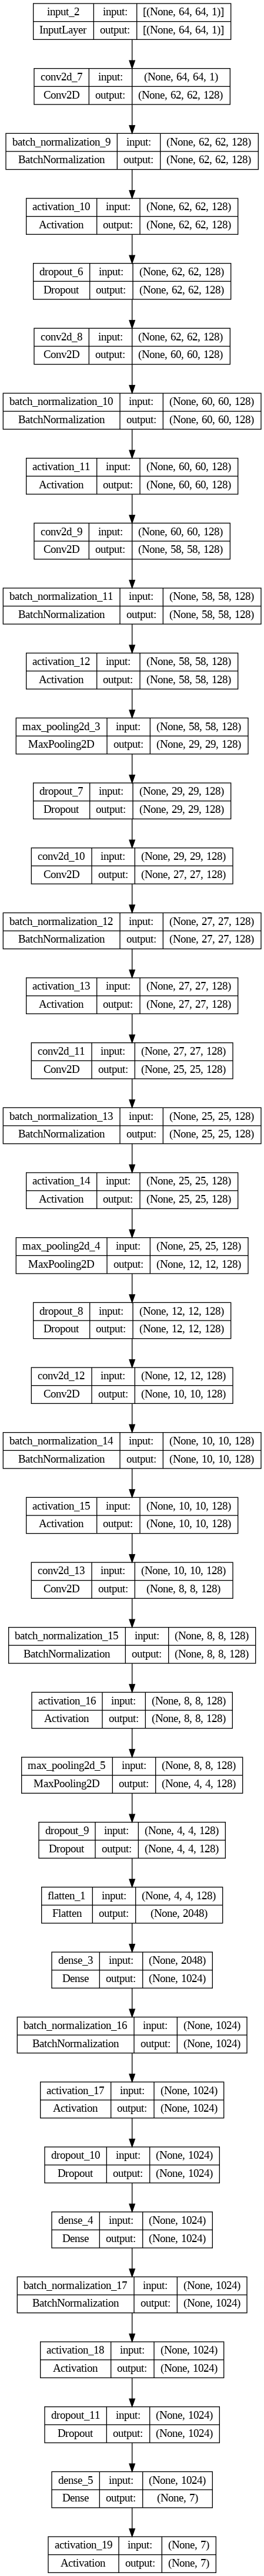

In [51]:
plot_model(model, to_file='model.png', show_shapes=True,show_layer_names=True)
Image(filename='model.png')

Defining Callbacks for training

In [52]:
#save the model at certain intervals - saving best model wrt to val_accuracy
mcp = ModelCheckpoint("./model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#stop training when val_loss has stopped improving - to avoid overfitting
es = EarlyStopping(monitor='val_loss',
                          min_delta=0.0001,
                          patience=20,
                          verbose=1,
                          restore_best_weights=True
                          )
#adjust the learning rate when val_loss stops improving
lrd = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=10,
                              verbose=1,
                              min_delta=0.0001)


Training the model

In [54]:

history = model.fit_generator(generator=train_set,
                                steps_per_epoch=train_set.n//train_set.batch_size,
                                epochs=60,
                                validation_data = valid_set,
                                validation_steps = valid_set.n//valid_set.batch_size,
                                callbacks=[mcp,es,lrd]
                                )

<ipython-input-54-cf2054139724>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


Epoch 1/60
358/358 [==============================] - ETA: 0s - loss: 1.8435 - accuracy: 0.2611
Epoch 1: val_accuracy improved from 0.25158 to 0.26492, saving model to ./model.h5
358/358 [==============================] - 63s 176ms/step - loss: 1.8435 - accuracy: 0.2611 - val_loss: 1.8795 - val_accuracy: 0.2649 - lr: 0.0010
Epoch 2/60
358/358 [==============================] - ETA: 0s - loss: 1.7767 - accuracy: 0.2992
Epoch 2: val_accuracy improved from 0.26492 to 0.28353, saving model to ./model.h5
358/358 [==============================] - 62s 173ms/step - loss: 1.7767 - accuracy: 0.2992 - val_loss: 1.9704 - val_accuracy: 0.2835 - lr: 0.0010
Epoch 3/60
358/358 [==============================] - ETA: 0s - loss: 1.7167 - accuracy: 0.3247
Epoch 3: val_accuracy improved from 0.28353 to 0.28757, saving model to ./model.h5
358/358 [==============================] - 60s 167ms/step - loss: 1.7167 - accuracy: 0.3247 - val_loss: 1.7015 - val_accuracy: 0.2876 - lr: 0.0010
Epoch 4/60
358/358 [==

Evaluating the accuracy using unseen training data (Test Data) which the model haven't encountered

In [55]:
# find the accuracy and loss on test set
test_loss, test_accuracy = model.evaluate(test_set)


print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')


113/113 [==============================] - 4s 34ms/step - loss: 0.9690 - accuracy: 0.6402
Test Accuracy: 64.02%
Test Loss: 0.9690


Plotting Loss Curves Of the Model

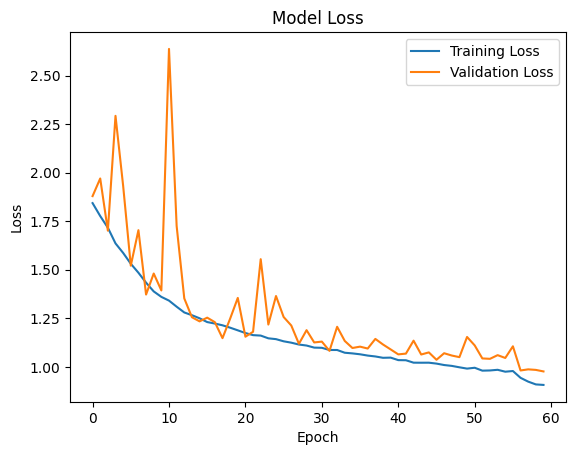

In [56]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

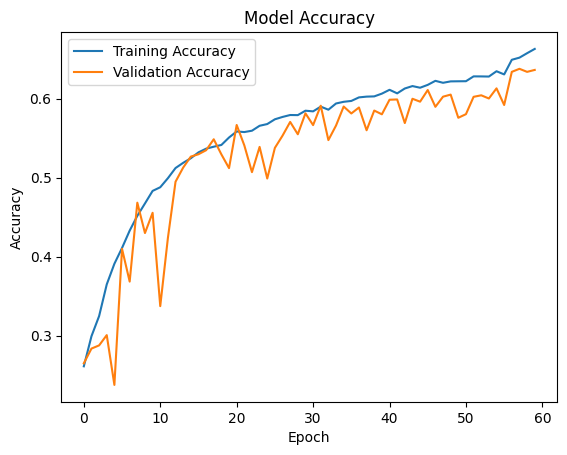

In [57]:
# Plot the training and validation loss
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

2/2 [==============================] - 0s 24ms/step


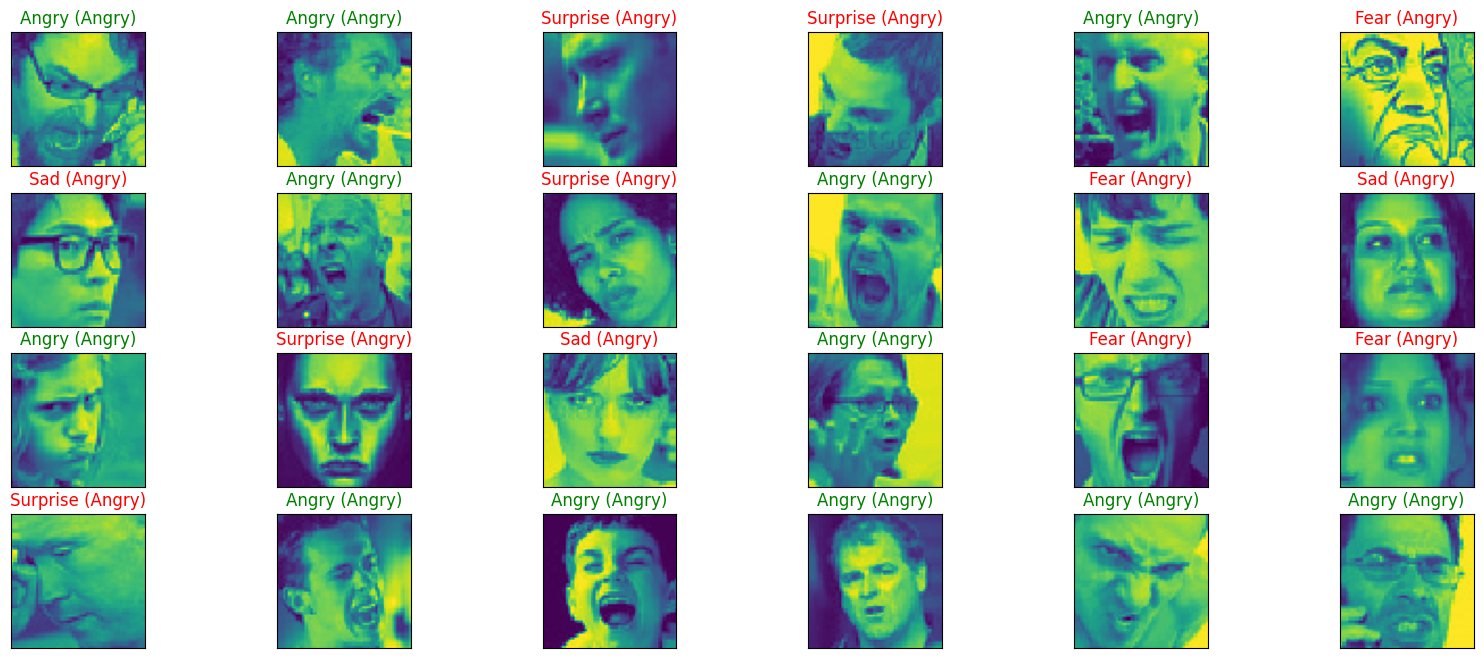

In [58]:
# Define label dictionary
labelDict = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

# Load and preprocess the test dataset using your test dataset generator
X_test, y_test = test_set.next()

# Make predictions on the test set
y_pred = model.predict(X_test)

# Create a figure to display the predictions
figure = plt.figure(figsize=(20, 8))

for i in range(min(24, X_test.shape[0])):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[i]))

    predict_index = labelDict[np.argmax(y_pred[i])]
    true_index = labelDict[np.argmax(y_test[i])]

    ax.set_title("{} ({})".format(predict_index, true_index), color=("green" if predict_index == true_index else "red"))

plt.show()


Confusion Matrix to visualize the performance of each class

<ipython-input-59-6f9a5ae88954>:12: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_set)


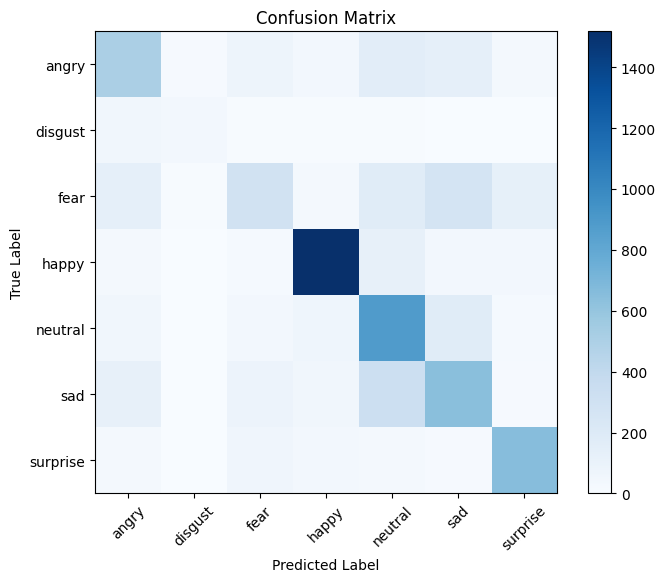

Classification Report:
               precision    recall  f1-score   support

       angry       0.55      0.53      0.54       958
     disgust       0.62      0.35      0.45       111
        fear       0.50      0.29      0.36      1024
       happy       0.87      0.86      0.86      1774
     neutral       0.52      0.71      0.60      1233
         sad       0.50      0.51      0.51      1247
    surprise       0.74      0.79      0.76       831

    accuracy                           0.63      7178
   macro avg       0.61      0.58      0.58      7178
weighted avg       0.63      0.63      0.62      7178



In [59]:
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model


# Load the trained model
model = load_model("model.h5")

# Get the true labels
true_labels = test_set.classes

# Generate predictions on the test set
predictions = model.predict_generator(test_set)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get class labels from the generator
class_labels = list(test_set.class_indices.keys())

# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add class labels as tick labels
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report for additional metrics
print("Classification Report:\n", classification_report(true_labels, predicted_labels,target_names=class_labels))


In [60]:
from prettytable import PrettyTable

# Calculate metrics
correctly_classified = np.diag(conf_matrix)
incorrectly_classified = np.sum(conf_matrix, axis=0) - correctly_classified
accuracy_per_class = correctly_classified / np.sum(conf_matrix, axis=1) * 100

# Create a PrettyTable
table = PrettyTable()
table.field_names = ["Class", "Correctly Classified", "Incorrectly Classified", "Accuracy (%)"]

for i, label in enumerate(class_labels):
    table.add_row([label, correctly_classified[i], incorrectly_classified[i], f"{accuracy_per_class[i]:.2f}"])

# Print the table
print(table)

+----------+----------------------+------------------------+--------------+
|  Class   | Correctly Classified | Incorrectly Classified | Accuracy (%) |
+----------+----------------------+------------------------+--------------+
|  angry   |         509          |          417           |    53.13     |
| disgust  |          39          |           24           |    35.14     |
|   fear   |         292          |          287           |    28.52     |
|  happy   |         1518         |          234           |    85.57     |
| neutral  |         878          |          823           |    71.21     |
|   sad    |         641          |          630           |    51.40     |
| surprise |         653          |          233           |    78.58     |
+----------+----------------------+------------------------+--------------+
